# seq2seq

This is an implementation of `seq2seq` using PyTorch. I figure this would be a good way of actually understanding on how to implement this kind of network. It looks like a pretty hefty many-to-many RNN that is split into two parts, an encoder and a decoder. We also have an attention variable which utilises the outputs of the encoders to help make a decision on the decoder's output. I'm using [this](https://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html) tutorial to help me build this model.

In [1]:
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import string
import re
import random
import os

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

For this particular problem I'll be following the official PyTorch tutorial for 'seq2seq' which involves attempting to translate english into french. 

## Parsing the Dataset

We'll need a dataset. We'll use [this one]( http://www.manythings.org/anki/). We'll start by loading this dataset and parsing it into a class.

In [2]:
# start_of_sentence and end_of_sentence token
SOS_token = 0
EOS_token = 1

class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {
            0: "SOS",
            1: "EOS"
        }
        self.n_words = len(self.index2word.keys())
    
    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)
    
    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

Note that the files are in unicode (since they may have accents); we'll need to turn them into ASCII. We can also use this opportunity to make everything lowercase, and trim punctuation.

In [3]:
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )
def norm(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    return s

We'll need to read the datafile, and split them by lines, and split lines into pairs.

In [4]:
def readLangs(lang1, lang2, reverse=False):
    print("Reading lines..")
    
    # read the file and split into lines
    directory = "../Datasets/Tutorials/seq2seq"
    filename = lang1 + "-" + lang2 + ".txt"
    filepath = os.path.join(directory, filename)
    lines = open(filepath, encoding='utf-8').\
        read().strip().split("\n")
    
    # split every line into pairs
    # note that the language phrases are split by a tab.
    pairs = [[norm(s) for s in l.split('\t')] for l in lines]
    
    # reverse the pairs
    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        input_lang = Lang(lang2)
        output_lang = Lang(lang1)
    else:
        input_lang = Lang(lang1)
        output_lang = Lang(lang2)
    
    return input_lang, output_lang, pairs

We'll want to trim the data into relatively short and simple sentences. Let the max length = 10 words, including punctuation.

In [5]:
max_length = 10

englishPrefixes = (
    "i am ", "i m ",
    "he is", "he s ",
    "she is", "she s",
    "you are", "you re ",
    "we are", "we re ",
    "they are", "they re "
    )

def filterPair(p):
    check1 = len(p[0].split(' ')) < max_length
    check2 = len(p[1].split(' ')) < max_length
    check3 = p[1].startswith(englishPrefixes)
    return check1 and check2 and check3

def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]

The process for sanitising the data looks like:

- Read the text file, split it into lines and pairs.
- Normalise the text.
- Make word lists from sentences in pairs.

In [6]:
def prepare(lang1, lang2, reverse=False):
    inputLang, outputLang, pairs = readLangs(lang1, lang2, reverse)
    print("Read %s sentence pairs." % len(pairs))
    
    pairs = filterPairs(pairs)
    print("Trimmed to %s sentence pairs." % len(pairs))
    
    print("Counting words..")
    
    for pair in pairs:
        inputLang.addSentence(pair[0])
        outputLang.addSentence(pair[1])
        
    print("Counted words:")
    print(inputLang.name, inputLang.n_words)
    print(outputLang.name, outputLang.n_words)
    
    return inputLang, outputLang, pairs

inputLang, outputLang, pairs = prepare("eng", "fra", True)
print(random.choice(pairs))

Reading lines..
Read 135842 sentence pairs.
Trimmed to 10853 sentence pairs.
Counting words..
Counted words:
fra 4489
eng 2925
['je ne suis pas le patron .', 'i m not the manager .']


## Preparing the Training Data

To train, we'll need to have input and target tensors based on the input data.

In [7]:
def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')]

def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1,1)

def tensorsFromPair(pair):
    inputTensor = tensorFromSentence(inputLang, pair[0])
    targetTensor = tensorFromSentence(outputLang, pair[1])
    return (inputTensor, targetTensor)

## The Seq2Seq Model

In this particular example we'll be using GRUs (gated recurrent units).

### Encoder

This part is a RNN that otuputs some value for every word from the input sentence. For every input word the encoder outputs some vector, and a hidden state. This hidden state is the input for the next input word.

In [8]:
class Encoder(nn.Module):
    def __init__(self, inputSize, hiddenSize):
        super(Encoder, self).__init__()
        self.hiddenSize = hiddenSize
        self.embedding = nn.Embedding(inputSize, hiddenSize)
        self.gru = nn.GRU(hiddenSize, hiddenSize)
    
    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1,1,-1)
        output = embedded
        output, hidden = self.gru(output, hidden)
        return output, hidden
    
    def initHidden(self):
        return torch.zeros(1,1, self.hiddenSize, device=device)

### Decoder

In the tutorial they describe the decoder as using the last output of the encoder as $y_0$. This is represented as the **context vector**. At each step of the encoding, the decoder is given an input token and a hidden state. The initial input token is the start of the string `<SOS>` (which we described at the beginning), and there is also an `<EOS>` (the end of string).

In [9]:
class Decoder(nn.Module):
    def __init__(self, hiddenSize, outputSize):
        super(Decoder, self).__init__()
        self.hiddenSize = hiddenSize
        
        self.embedding = nn.Embedding(outputSize, hiddenSize)
        self.gru = nn.GRU(hiddenSize, hiddenSize)
        self.out = nn.Linear(hiddenSize, outputSize)
        self.softmax = nn.LogSoftmax(dim=1)
    
    def forward(self, input, hidden):
        output = self.embedding(input).view(1,1,-1)
        output = F.relu(output)
        output, hidden = self.gru(output, hidden)
        output = self.softmax(self.out(output[0]))
        return output, hidden
    
    def initHidden(self):
        return torch.zeros(1,1, self.hiddenSize, device=device)

### Attention Decoder
 
This is the attention mechanism which makes this network model different from the others. The Attention mechanism allows the decoder to *focus* on a different part of the encoders outputs for every step of the decoder's own inputs. Here's a TLDR:

- Calculate a set of attention weights.
- Dot product the attention weights with the encoder output vectors.
- This result should contain information about that specific part of the input sequence, which helps the decoder choose the right words. We'll store this into a variable called `attentionApplied`.

Calculating the attention weights is done with another feed-forward layer `attention`, using the decoder's inputs and hidden states as inputs. There's sentences of all sizes so we'll need to choose a maximum sentence length (i.e the input length for the decoder outputs) that it can apply to.

In [10]:
class AttentionDecoder(nn.Module):
    def __init__(self, hiddenSize, outputSize, dropout=0.1, maxLength = max_length):
        super(AttentionDecoder, self).__init__()
        self.hiddenSize = hiddenSize
        self.outputSize = outputSize
        self.dropoutProbability = dropout
        self.maxLength = maxLength
        
        self.embedding = nn.Embedding(self.outputSize, self.hiddenSize)
        self.attention = nn.Linear(self.hiddenSize * 2, self.maxLength)
        self.attentionCombined = nn.Linear(self.hiddenSize * 2, self.hiddenSize)
        self.dropout = nn.Dropout(self.dropoutProbability)
        self.gru = nn.GRU(self.hiddenSize, self.hiddenSize)
        self.out = nn.Linear(self.hiddenSize, self.outputSize)
    
    def forward(self, input, hidden, encoderOutputs):
        embedded = self.embedding(input).view(1,1,-1)
        embedded = self.dropout(embedded)
        
        attentionWeights = F.softmax(
            self.attention(torch.cat((embedded[0], hidden[0]), 1)), dim=1)
        attentionApplied = torch.bmm(attentionWeights.unsqueeze(0),
                                    encoderOutputs.unsqueeze(0))
        
        output = torch.cat((embedded[0], attentionApplied[0]), 1)
        output = self.attentionCombined(output).unsqueeze(0)
        
        output = F.relu(output)
        output, hidden = self.gru(output, hidden)
        
        output = F.log_softmax(self.out(output[0]), dim=1)
        return output, hidden, attentionWeights

    
    def initHidden(self):
        return torch.zeros(1,1, self.hiddenSize, device=device)
    
        

## Training the Model

We'll need to run the input sequence through the encoder, keep track of the outputs, and the latest hidden state. Then we'll feed the decoder the `<SOS>` token and the latest hidden state as it's first hidden state.

In [11]:
teacherForcingRatio = 0.5

def train(tensorIn, tensorOut, encoder, decoder, encoderOptimiser, decoderOptimiser, criterion, maxLength = max_length):
    encoderHidden = encoder.initHidden()
    
    encoderOptimiser.zero_grad()
    decoderOptimiser.zero_grad()
    
    inputLength = tensorIn.size(0)
    targetLength = tensorOut.size(0)
    
    loss = 0
    
    # set up encoder computation
    encoderOutputs = torch.zeros(maxLength, encoder.hiddenSize, device=device)

    for ei in range(inputLength):
        encoderOutput, encoderHidden = encoder(tensorIn[ei], encoderHidden)
        encoderOutputs[ei] = encoderOutput[0,0]
    
    # set up decoder variables
    decoderInput = torch.tensor([[SOS_token]], device=device)
    decoderHidden = encoderHidden
    
    enableTeacherForcing = False
    if random.random() < teacherForcingRatio:
        enableTeacherForcing = True
    
    if enableTeacherForcing:
        # teacher forcing: feeds the target as the next input.
        for di in range(targetLength):
            # compute the output of each decoder state
            decoderOutput, decoderHidden, decoderAttention = decoder(decoderInput, decoderHidden, encoderOutputs)
            # calculate the loss
            loss += criterion(decoderOutput, tensorOut[di])
            # feed this output to the next input
            decoderInput = tensorOut[di]
    else:
        # no techer forcing: use the predicted output as the next input.
        for di in range(targetLength):
            # compute the output of each decoder state
            decoderOutput, decoderHidden, decoderAttention = decoder(decoderInput, decoderHidden, encoderOutputs)
            toPV, toPI = decoderOutput.topk(1)
            # detach from history as input
            decoderInput = toPI.squeeze().detach()
            # calculate the loss
            loss += criterion(decoderOutput, tensorOut[di])
            # if we found `<EOS>` at this iteration, then break.
            if decoderInput.item() == EOS_token:
                break
    
    loss.backward()
    encoderOptimiser.step()
    decoderOptimiser.step()
    
    return loss.item()/targetLength

Here's a helper function to print the time elapsed and the estimated time remaining given the current time and progress:

In [12]:
import time
import math


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

The training process looks something like this:

- Start a timer.
- Initialise optimisers and criterion.
- Create set of training pairs.
- Start empty losses array for plotting.

Then we'll call `train` many times and occasionally print the progress and average loss.

In [13]:
def trainIters(encoder, decoder, iterations, printEvery=1000, plotEvery=100, learningRate=0.01):
    # store statistics so we can use them to 
    # show progress.
    start = time.time()
    plotLosses = []
    printLossTotal = 0
    plotLossTotal = 0
    
    # setup optimisers
    encoderOptimiser = optim.SGD(encoder.parameters(), lr=learningRate)
    decoderOptimiser = optim.SGD(decoder.parameters(), lr=learningRate)
    trainingPairs = [tensorsFromPair(random.choice(pairs)) for i in range(iterations)]
    criterion = nn.NLLLoss()
    
    for i in range(1, iterations + 1):
        # set up variables needed for training.
        trainingPair = trainingPairs[i-1]
        tensorIn, tensorOut = trainingPair[0], trainingPair[1]
        # calculate loss.
        loss = train(tensorIn, tensorOut, encoder, decoder, encoderOptimiser, decoderOptimiser, criterion)
        # increment our print and plot.
        printLossTotal += loss
        plotLossTotal += loss
        
        # print mechanism
        if i % printEvery == 0:
            printLossAvg = printLossTotal / printEvery
            # reset the print loss.
            printLossTotal = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, i / iterations),
                                         i, i / iterations * 100, printLossAvg))
        # plot mechanism
        if i % plotEvery == 0:
            plotLossAvg = plotLossTotal / plotEvery
            plotLosses.append(plotLossAvg)
            plotLossTotal = 0
    
    showPlot(plotLosses)

### Plotting Results

Involves `matplotlib`, using the array of loss `plot_losses` saved while training.

In [14]:
import matplotlib.pyplot as plt
plt.switch_backend('agg')
import matplotlib.ticker as ticker
import numpy as np


def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

## Evaluation

Looks like training, but there's no targets so we feed the decoder's predictions back to itself for each step. Every time it predicts a word, we add it to the output string, and if it predicts the EOS token we stop there. We also store the decoder's attention outputs for display later.

In [15]:
def evaluate(encoder, decoder, sentence, maxLength = max_length):
    with torch.no_grad():
        decodedWords = []
        
        # set up encoder
        tensorIn = tensorFromSentence(inputLang, sentence)
        inputLength = tensorIn.size()[0]
        encoderHidden = encoder.initHidden()
        encoderOutputs = torch.zeros(maxLength, encoder.hiddenSize, device=device)
        
        # add variables into our encoder.
        for i in range(inputLength):
            encoderOutput, encoderHidden = encoder(tensorIn[i], encoderHidden)
            encoderOutputs[i] += encoderOutput[0,0]
        
        # set up decoder
        decoderInput = torch.tensor([[SOS_token]], device=device)
        decoderHidden = encoderHidden
        decoderAttentions = torch.zeros(maxLength, maxLength)
        
        # iterate through the decoder states and retrieve
        # the outputs.
        for i in range(maxLength):
            decoderOutput, decoderHidden, decoderAttention = decoder(decoderInput, decoderHidden, encoderOutputs)
            decoderAttentions[i] = decoderAttention.data
            toPV, toPI = decoderOutput.data.topk(1)
            
            # if we found the end of string token then we're done.
            if toPI.item() == EOS_token:
                decodedWords.append('<EOS>')
                break
            else:
                decodedWords.append(outputLang.index2word[toPI.item()])
            
            # format toPI to something the decoder can understand.
            decoderInput = toPI.squeeze().detach()
        
        return decodedWords, decoderAttentions[:i + 1]

We'll also evaluate random sentences from the training set and print the input, target, and output to make some subjective QA.

In [16]:
def evaluateRandomly(encoder, decoder, n=10):
    for i in range(n):
        pair = random.choice(pairs)
        print('>', pair[0])
        print('=', pair[1])
        output_words, attentions = evaluate(encoder, decoder, pair[0])
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')

In [17]:
# ## Training & Evaluating

# hiddenSize = 256
# modelEncoder = Encoder(inputLang.n_words, hiddenSize).to(device)
# modelDecoder = Decoder(hiddenSize, outputLang.n_words).to(device)
# print(type(modelDecoder))
# trainIters(modelEncoder, modelDecoder, 75000, printEvery=1000)

0m 30s (- 37m 23s) (1000 1%) 3.5416
0m 55s (- 33m 36s) (2000 2%) 2.9034
1m 20s (- 32m 16s) (3000 4%) 2.7680
1m 46s (- 31m 22s) (4000 5%) 2.6376
2m 11s (- 30m 39s) (5000 6%) 2.5176
2m 36s (- 30m 5s) (6000 8%) 2.5169
3m 2s (- 29m 30s) (7000 9%) 2.4100
3m 27s (- 28m 58s) (8000 10%) 2.3057
3m 53s (- 28m 30s) (9000 12%) 2.2590
4m 18s (- 28m 3s) (10000 13%) 2.1882
4m 44s (- 27m 33s) (11000 14%) 2.1224
5m 9s (- 27m 6s) (12000 16%) 2.0438
5m 35s (- 26m 40s) (13000 17%) 1.9994
6m 1s (- 26m 13s) (14000 18%) 1.8651
6m 27s (- 25m 48s) (15000 20%) 1.8701
6m 52s (- 25m 22s) (16000 21%) 1.8237
7m 18s (- 24m 57s) (17000 22%) 1.8093
7m 44s (- 24m 31s) (18000 24%) 1.7793
8m 10s (- 24m 5s) (19000 25%) 1.7534
8m 36s (- 23m 39s) (20000 26%) 1.6826
9m 1s (- 23m 13s) (21000 28%) 1.6179
9m 27s (- 22m 48s) (22000 29%) 1.5762
9m 53s (- 22m 22s) (23000 30%) 1.5849
10m 19s (- 21m 56s) (24000 32%) 1.4803
10m 45s (- 21m 31s) (25000 33%) 1.5067
11m 11s (- 21m 5s) (26000 34%) 1.4365
11m 37s (- 20m 40s) (27000 36%) 1.

<Figure size 432x288 with 0 Axes>

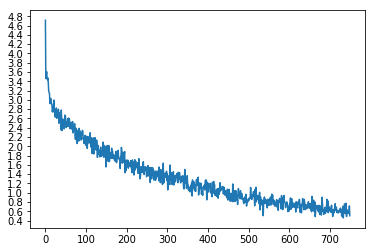

In [18]:
## Training & Evaluating

hiddenSize = 256
modelEncoder = Encoder(inputLang.n_words, hiddenSize).to(device)
modelAttentionDecoder = AttentionDecoder(hiddenSize, outputLang.n_words, dropout=0.1).to(device)
trainIters(modelEncoder, modelAttentionDecoder, 75000, printEvery=1000)

## Results

Now that our seq2seq model has finished training, we can see how good it is:

In [19]:
evaluateRandomly(modelEncoder, modelAttentionDecoder)

> je suis moins heureux maintenant .
= i m not as happy now .
< i m only only now . <EOS>

> il est anglais .
= he is english .
< he is english . <EOS>

> c est une chanteuse pas banale .
= she is no ordinary singer .
< she is a singer . <EOS>

> elles sont surprises .
= they re surprised .
< they re surprised . <EOS>

> je suis punie .
= i m being punished .
< i m being punished . <EOS>

> nous sommes sinceres .
= we re sincere .
< we re depressed . <EOS>

> vous etes fort contraries .
= you re very upset .
< you re very upset . <EOS>

> je suis completement confuse .
= i am totally confused .
< i m totally confused . <EOS>

> je suis agriculteur .
= i m a farmer .
< i m a . . <EOS>

> je suis le plus jeune enfant .
= i m the youngest child .
< i m the youngest child . <EOS>



## Visualising Attention

We can interpret the attention outputs - it's quite useful since they're used to weight specific encoder outputs of the input sequence. With this, we can see where the network is most focused at each time step.

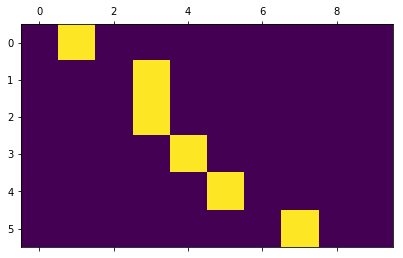

In [20]:
output_words, attentions = evaluate(
    modelEncoder, modelAttentionDecoder, "je suis trop froid .")
plt.matshow(attentions.numpy())

In [21]:
def showAttention(input_sentence, output_words, attentions):
    # Set up figure with colorbar
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions.numpy(), cmap='bone')
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticklabels([''] + input_sentence.split(' ') +
                       ['<EOS>'], rotation=90)
    ax.set_yticklabels([''] + output_words)

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()


def evaluateAndShowAttention(input_sentence):
    output_words, attentions = evaluate(
        modelEncoder, modelAttentionDecoder, input_sentence)
    print('input =', input_sentence)
    print('output =', ' '.join(output_words))
    showAttention(input_sentence, output_words, attentions)

input = elle a cinq ans de moins que moi .
output = she s five years younger than me . <EOS>


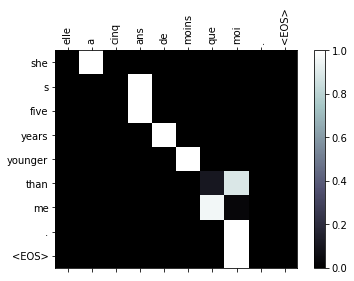

In [22]:
evaluateAndShowAttention("elle a cinq ans de moins que moi .")

input = elle est trop petit .
output = she s too short . <EOS>


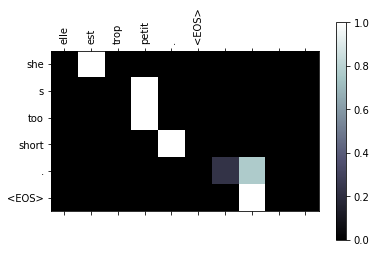

In [23]:
evaluateAndShowAttention("elle est trop petit .")

input = je ne crains pas de mourir .
output = i m afraid i dying . <EOS>


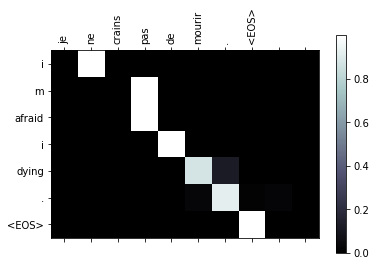

In [24]:
evaluateAndShowAttention("je ne crains pas de mourir .")

input = c est un jeune directeur plein de talent .
output = he s a talented young young . <EOS>


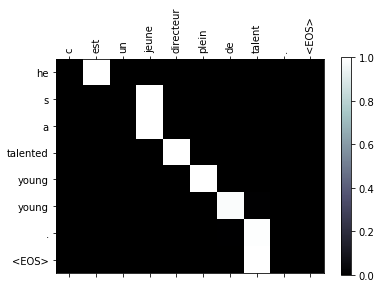

In [25]:
evaluateAndShowAttention("c est un jeune directeur plein de talent .")

input = et tu .
output = you re stalling . <EOS>


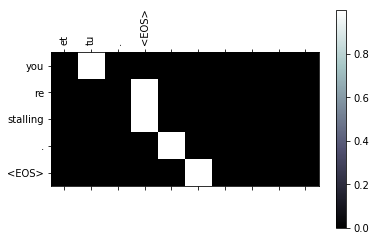

In [26]:
evaluateAndShowAttention("et tu .")